# Explority data analysis (EDA)
- Some investigation of the dataset before doing the clean and feature engineering

In [1]:
#Import libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xlwings import view
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, ElasticNetCV, Lasso, LassoCV

## Data Preprocessing

In [2]:
#Read dataset
train_df = pd.read_csv('data/train.csv', sep = ',')
test_df = pd.read_csv('data/test.csv', sep = ',')

### Check of data

In [3]:
#Shape
print("----- SHAPE -----")
train_df.shape

----- SHAPE -----


(1460, 81)

In [4]:
#Info
print("----- INFO -----")
train_df.info()

----- INFO -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int6

In [5]:
for i in test_df.columns:
    if test_df[i].dtype != train_df[i].dtype:
        print(i, test_df[i].dtype, train_df[i].dtype)
        test_df[i] = test_df[i].fillna(0)
        test_df[i] = test_df[i].astype(int)
        print(i, test_df[i].dtype, train_df[i].dtype)

BsmtFinSF1 float64 int64
BsmtFinSF1 int64 int64
BsmtFinSF2 float64 int64
BsmtFinSF2 int64 int64
BsmtUnfSF float64 int64
BsmtUnfSF int64 int64
TotalBsmtSF float64 int64
TotalBsmtSF int64 int64
BsmtFullBath float64 int64
BsmtFullBath int64 int64
BsmtHalfBath float64 int64
BsmtHalfBath int64 int64
GarageCars float64 int64
GarageCars int64 int64
GarageArea float64 int64
GarageArea int64 int64


## Correlation matrix

## Handle Missing values

In [6]:
#Checking features for missing value by getting the percentage of missing values

missing_values_percent = [(col,train_df[col].isna().mean() * 100) for col in train_df]
missing_values_percent = pd.DataFrame(missing_values_percent, columns = ["column_name", "percentage"])

### Features with Null values

/var/folders/_0/wx2hxqy90vl4lrsknhfp343w0000gn/T/ipykernel_42847/3633100850.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_values.sort_values(by = "percentage", ascending=False, inplace=True)


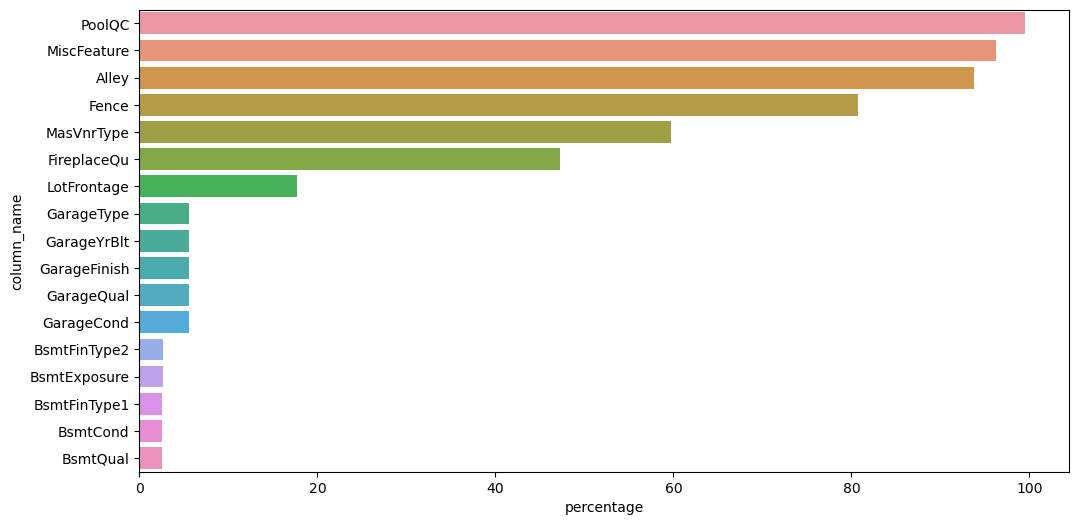

In [7]:
#Fetch features with more than 1% missing values
missing_values = missing_values_percent[missing_values_percent.percentage > 1]

#Sort by descending percentage
missing_values.sort_values(by = "percentage", ascending=False, inplace=True)

plt.figure(figsize=(12,6))
sns.barplot(missing_values, x="percentage", y = "column_name")
plt.show()

Features with more than 80% missing values can be dropped. Drop PoolQC, MiscFeature, Alley and Fence 

In [8]:
train1_df = train_df.copy()
train1_df = train1_df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'Id'], axis = 1)

In [9]:
null_columns = train1_df.isna().sum()
null_columns = null_columns[null_columns > 0]
null_columns

LotFrontage     259
MasVnrType      872
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

The NAN-values in the categorical features are likely to represent that the feature is not present in that category. E.g. we can see that there are 81 that does not have a garage, and all the fatures related to garage are NaN. We can see that there might be some inconsistency in the dataset as for Bsmt there is some features with 37 Null Values and some with 38 NullValues. We can therefore do some more analysis on this. 

In [10]:
# Check for rows with Bsmt inconsistencies
print('Count\t #\t BsmtQual\t BsmtExposure\t BsmtFinType1\t BsmtFinType2\t BsmtCond')
s=0
df = pd.DataFrame(columns=['Count', '#', 'BsmtQual','BsmtExposure', 'BsmtFinType1','BsmtFinType2','BsmtCond'])
for i in range(len(train1_df)):
    if train1_df['BsmtExposure'].isnull()[i] or train1_df['BsmtFinType2'].isnull()[i] == True:
        if train1_df['BsmtCond'].isnull()[i] == False:
            s+=1
            new_row = {'Count':s, '#':i,'BsmtQual' : train1_df['BsmtQual'].isnull()[i],
                       'BsmtExposure':train1_df['BsmtExposure'].isnull()[i],
                       'BsmtFinType1' :train1_df['BsmtFinType1'].isnull()[i],
                       'BsmtFinType2' :train1_df['BsmtFinType2'].isnull()[i],
                       'BsmtCond' :train1_df['BsmtCond'].isnull()[i]}
            df = df._append(new_row, ignore_index = True)

Count	 #	 BsmtQual	 BsmtExposure	 BsmtFinType1	 BsmtFinType2	 BsmtCond


Inconsistency in row 332 and row 948, so we can delete those two rows. 

In [11]:
train1_df = train1_df.drop([332, 948], axis = 0).reset_index(drop = True)

### Splitting categorical and numerical features

In [12]:
#Fetch the numerical and categorical features
num_features_df = train1_df.select_dtypes(include = [np.number])
cat_features_df = train1_df.select_dtypes(include = ["object"])

### Numerical features

In [13]:
#Fill missing values with mean
num_features_df = num_features_df.fillna(num_features_df.mean())

#### Histogram of all numerical features

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

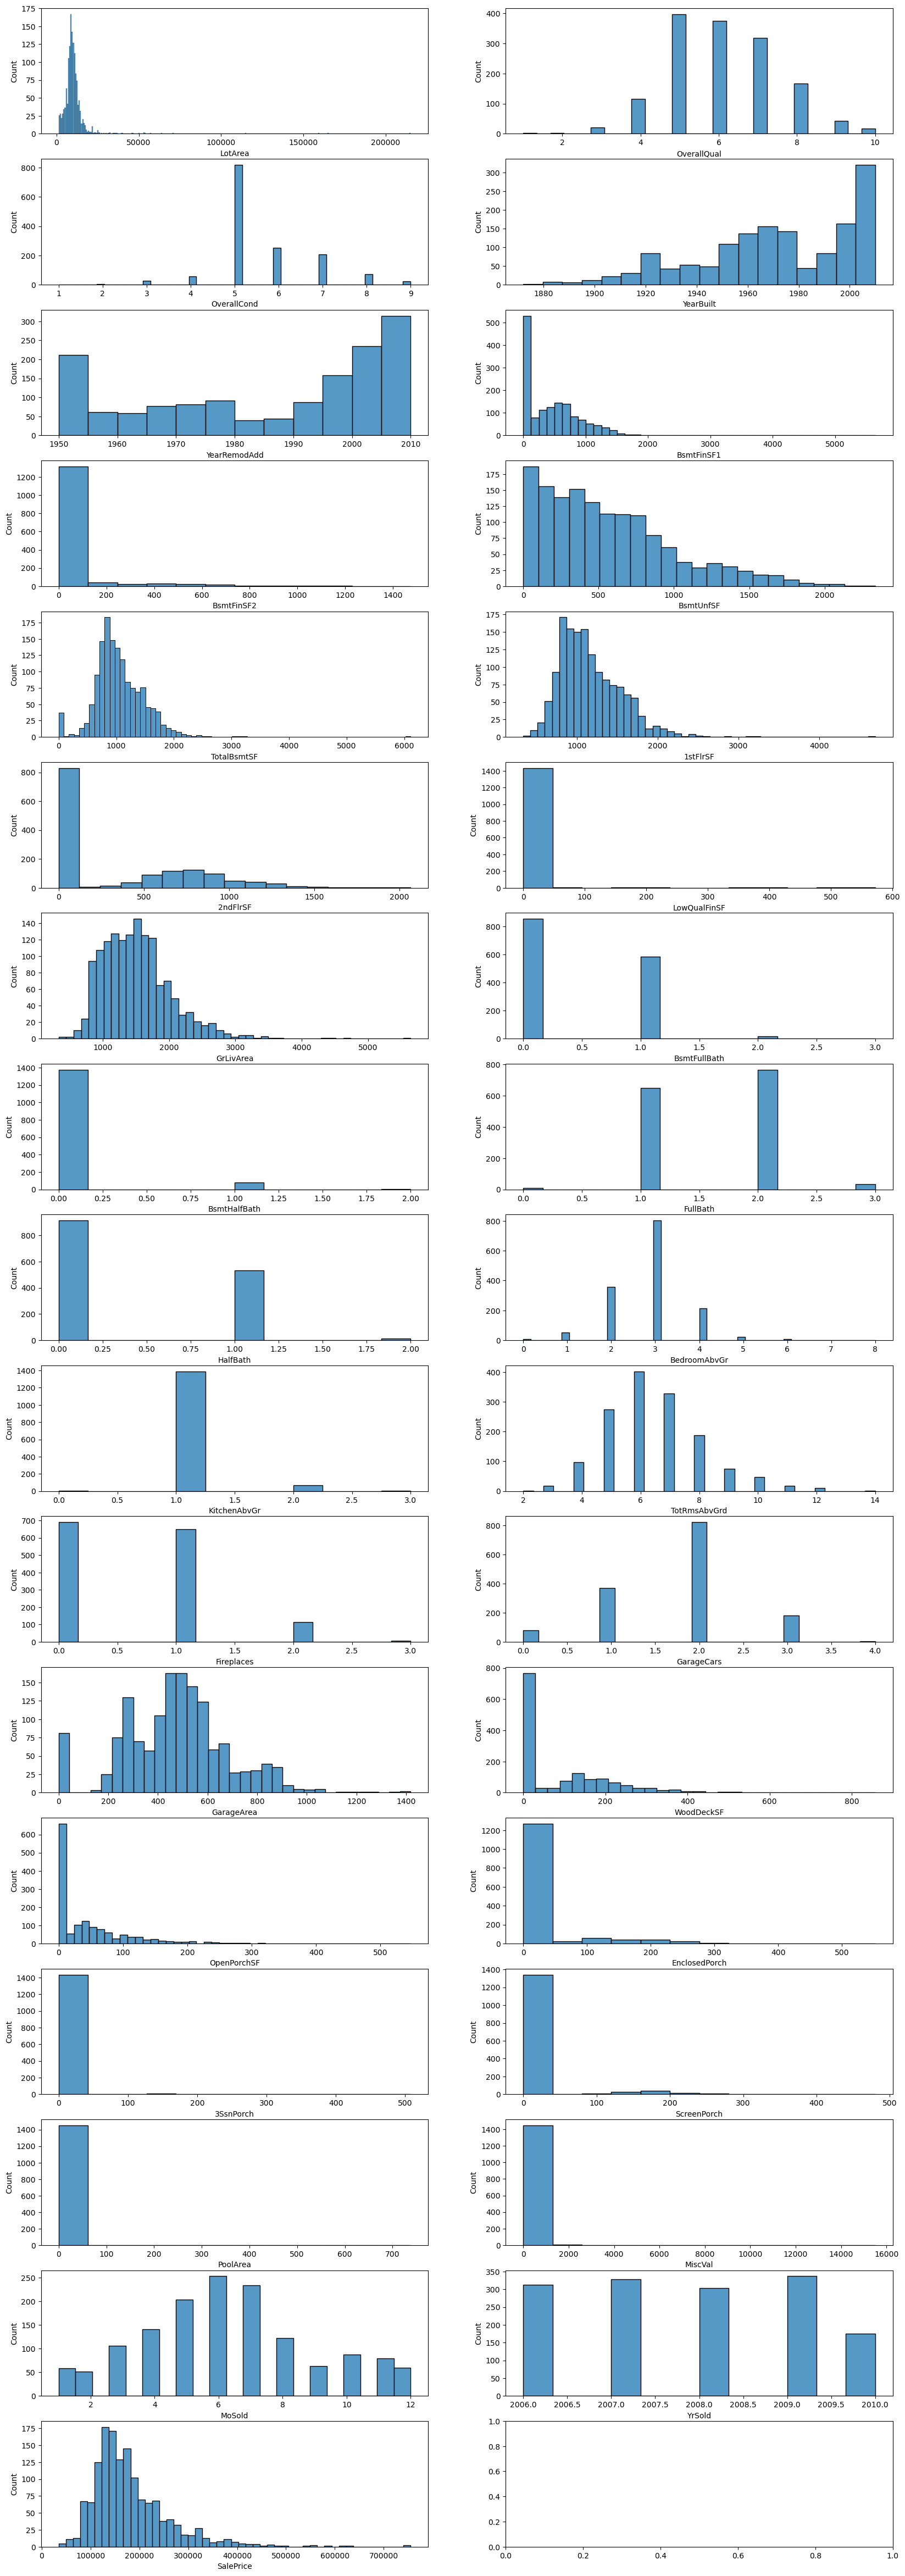

In [14]:
fig, axes = plt.subplots(17, 2, figsize=(20, 60), sharey=False)

s, r, c = 0,0,0
for i in num_features_df.columns:
    if num_features_df[i].dtype == 'int64':
        s+=1
        if s > 1 and r < 17:
            sns.histplot(num_features_df[i], ax = axes[r,c])
            c += 1
            if c > 1:
                r+=1; c = 0

In [15]:
#Drop columns
train_df = train_df.drop(columns=['PoolArea', 'MiscVal', 'Alley', 'Fence', ])

#### Correlation matrix for numerical features

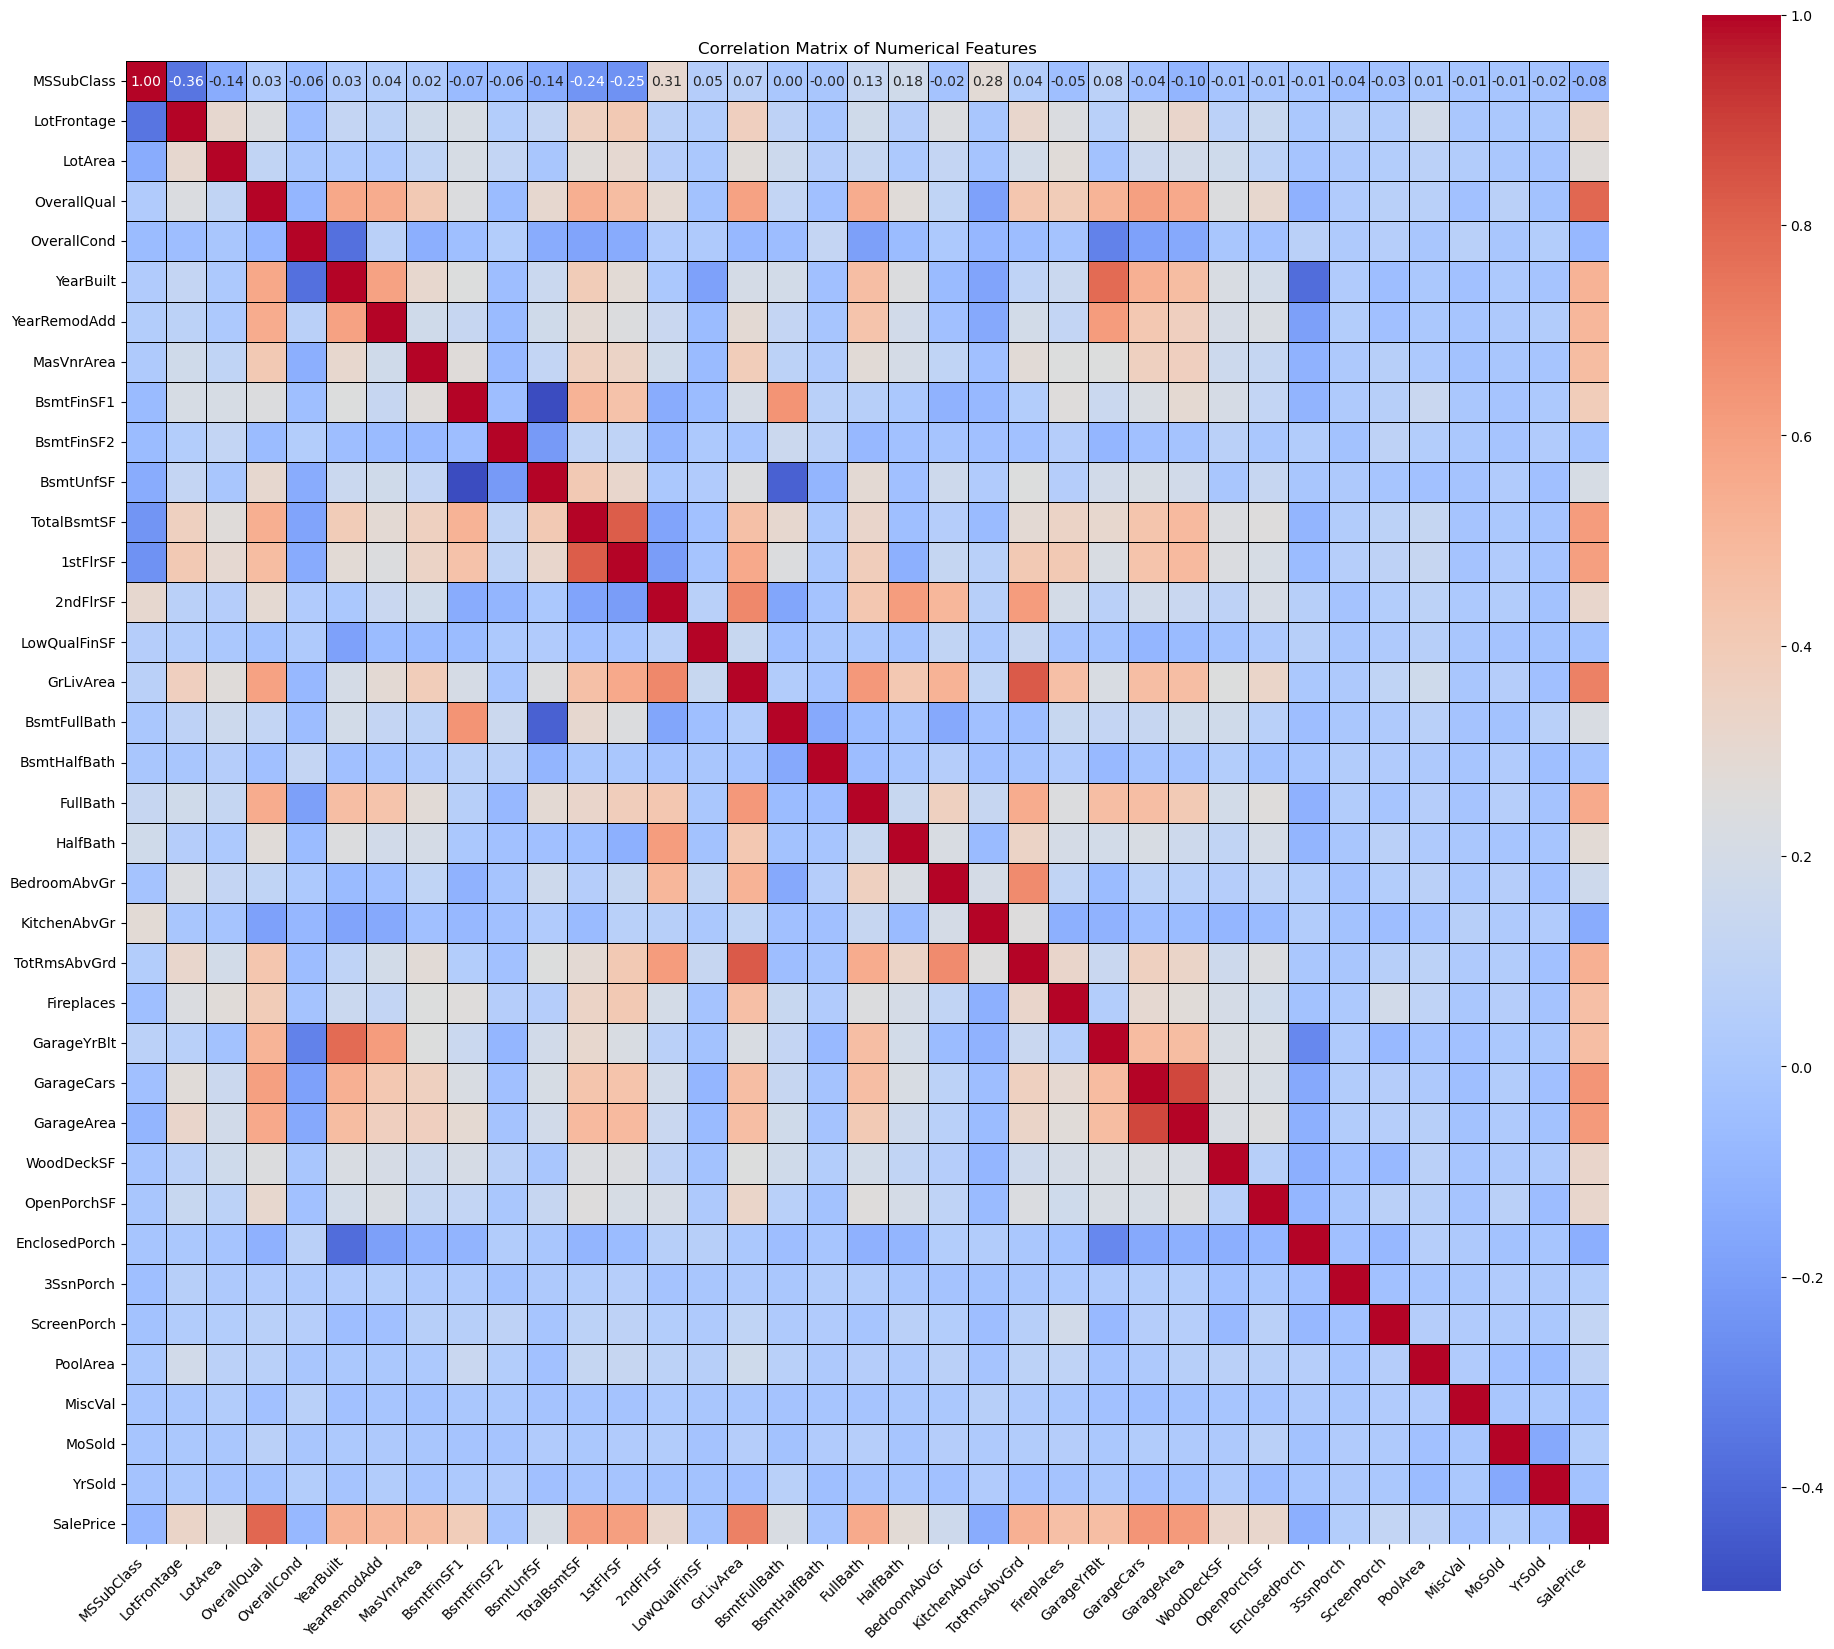

In [16]:
num_df_tmp = num_features_df.copy()
corr = num_features_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot = True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8},linewidths=.5, linecolor='black' )
plt.title('Correlation Matrix of Numerical Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [17]:
corr_target = corr['SalePrice'].sort_values(ascending=False)
threshold = 0.5
high_corr_features = corr_target[abs(corr_target) > threshold].index
high_corr_matrix = num_features_df[high_corr_features].corr()
styled_corr_matrix = high_corr_matrix.style.background_gradient(cmap='coolwarm')
styled_corr_matrix = high_corr_matrix.style.background_gradient(cmap='coolwarm', axis=None).set_properties(**{'max-width': '80px', 'font-size': '10pt'})
styled_corr_matrix
#plt.figure(figsize=(8, 6))
#sns.heatmap(high_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
#plt.title('Correlation Matrix of Highly Correlated Features')
#plt.show()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
SalePrice,1.000000,0.790783,0.708868,0.639903,0.622875,0.614699,0.605565,0.560449,0.533774,0.522549,0.506758
OverallQual,0.790783,1.000000,0.593112,0.600032,0.561368,0.538197,0.476020,0.550174,0.427405,0.571750,0.550168
GrLivArea,0.708868,0.593112,1.000000,0.467396,0.469344,0.458076,0.566451,0.629959,0.825477,0.198673,0.287150
GarageCars,0.639903,0.600032,0.467396,1.000000,0.882270,0.433106,0.438772,0.469264,0.362262,0.537357,0.420025
GarageArea,0.622875,0.561368,0.469344,0.882270,1.000000,0.484888,0.489119,0.405299,0.337874,0.478524,0.371045
TotalBsmtSF,0.614699,0.538197,0.458076,0.433106,0.484888,1.000000,0.822687,0.324041,0.287027,0.391644,0.290670
1stFlrSF,0.605565,0.476020,0.566451,0.438772,0.489119,0.822687,1.000000,0.380699,0.409667,0.281906,0.240222
FullBath,0.560449,0.550174,0.629959,0.469264,0.405299,0.324041,0.380699,1.000000,0.554734,0.467694,0.438515
TotRmsAbvGrd,0.533774,0.427405,0.825477,0.362262,0.337874,0.287027,0.409667,0.554734,1.000000,0.095244,0.191495
YearBuilt,0.522549,0.571750,0.198673,0.537357,0.478524,0.391644,0.281906,0.467694,0.095244,1.000000,0.592357


In [18]:
# Correlation with target value
corr_price = corr["SalePrice"]
corr_price_table = corr_price.to_frame()
corr_price_table.style.background_gradient(cmap = "coolwarm")

,SalePrice
MSSubClass,-0.083586
LotFrontage,0.334574
LotArea,0.263961
OverallQual,0.790783
OverallCond,-0.077403
YearBuilt,0.522549
YearRemodAdd,0.506758
MasVnrArea,0.474738
BsmtFinSF1,0.385835
BsmtFinSF2,-0.013777


#### Categorical features

In [19]:
cat_features_df.dtypes

MSZoning         object
Street           object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
SaleType         object
SaleCondition    object
dtype: object

### Plots 

#### Distribution of house prices

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

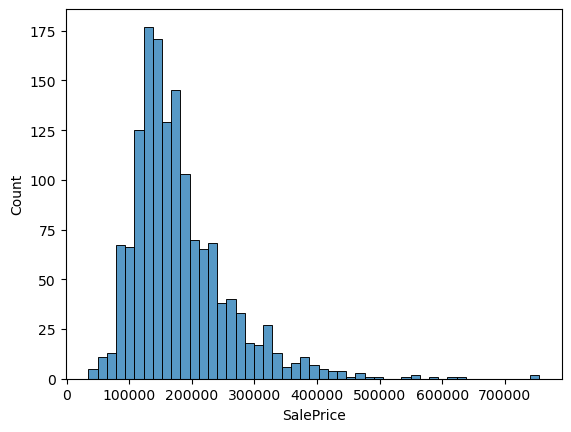

In [20]:
#Plots
sns.histplot(train_df['SalePrice'])

#### Distribution of numerical features 


array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>],
       [<Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>],
       [<Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>],
       [<Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,

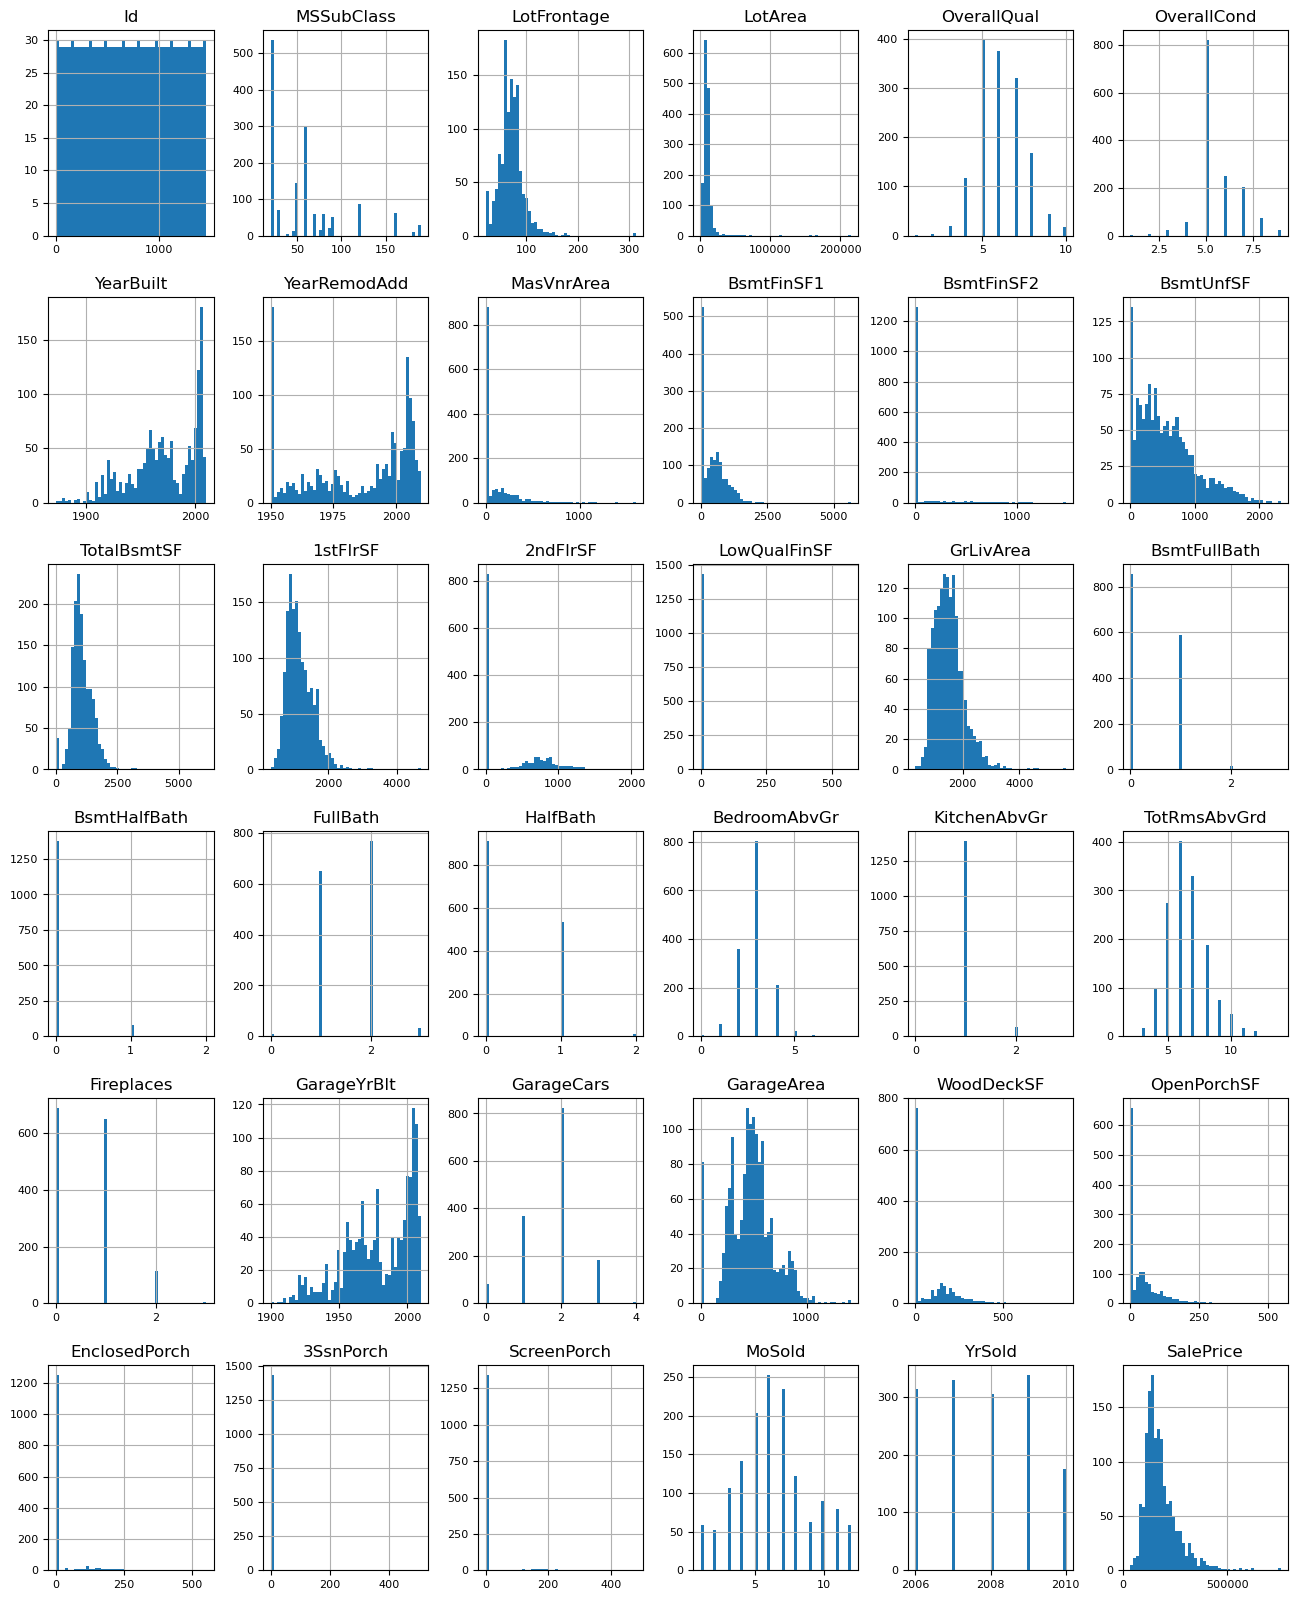

In [21]:
list(set(train_df.dtypes.to_list()))
train_df_num = train_df.select_dtypes(include = ['float64', 'int64'])
train_df_num.hist(figsize=(16,20), bins = 50, xlabelsize=8, ylabelsize=8)

/var/folders/_0/wx2hxqy90vl4lrsknhfp343w0000gn/T/ipykernel_42847/2532619159.py:1: FutureWarning: The provided callable <function median at 0x103ea31a0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  quality_pivot = train_df.pivot_table(index = "OverallQual", values='SalePrice', aggfunc=np.median)


Text(0, 0.5, 'SalePrice')

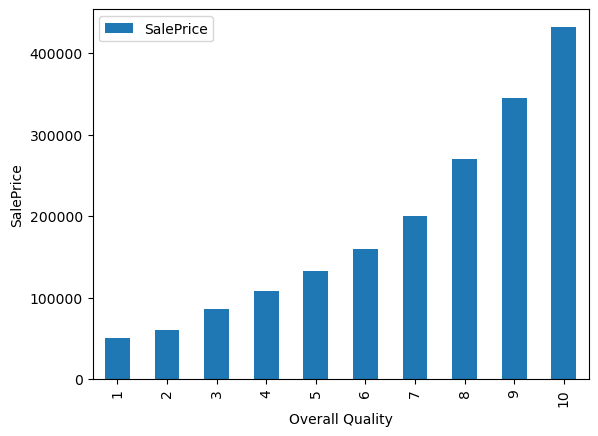

In [22]:
quality_pivot = train_df.pivot_table(index = "OverallQual", values='SalePrice', aggfunc=np.median)
quality_pivot.plot(kind = 'bar')
plt.xlabel('Overall Quality')
plt.ylabel('SalePrice')

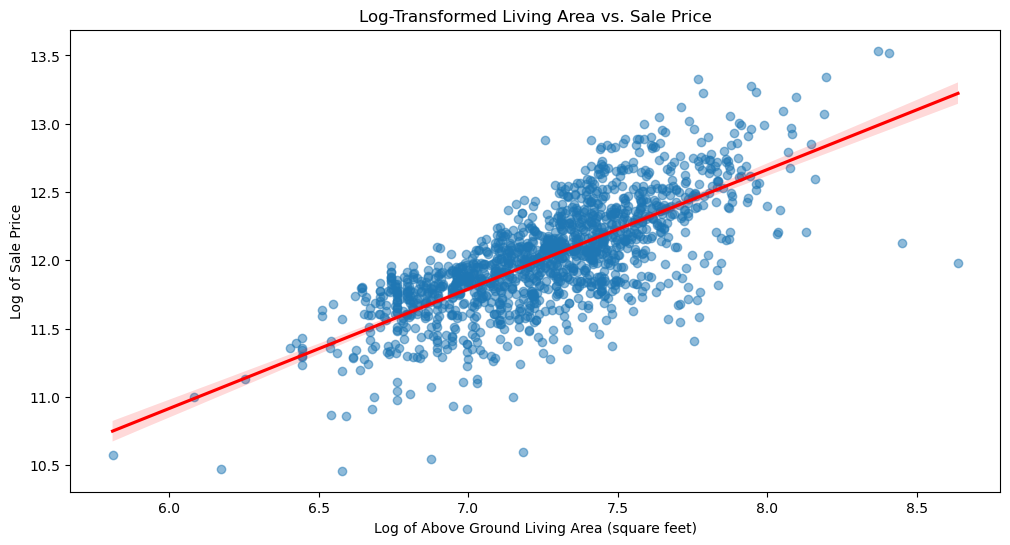

In [23]:
#Normalize the data
train_df_norm = train_df.copy()
train_df_norm['GrLivArea_log'] = np.log(train_df_norm['GrLivArea'])
train_df_norm['SalePrice_log'] = np.log(train_df_norm['SalePrice'])
plt.figure(figsize=(12,6))
data = pd.concat([train_df_norm['GrLivArea_log'], train_df_norm['SalePrice_log']], axis = 1)
sns.regplot(
    data = data,
    x = 'GrLivArea_log',
    y='SalePrice_log', 
    scatter_kws={'alpha':0.5},
    line_kws={'color':'red'}
)
plt.title('Log-Transformed Living Area vs. Sale Price')
plt.xlabel('Log of Above Ground Living Area (square feet)')
plt.ylabel('Log of Sale Price')
plt.show()

In [24]:
#Unique values 
unique_counts = train_df.nunique()
unique_counts

Id               1460
MSSubClass         15
MSZoning            5
LotFrontage       110
LotArea          1073
                 ... 
MoSold             12
YrSold              5
SaleType            9
SaleCondition       6
SalePrice         663
Length: 77, dtype: int64

In [25]:
#Finding irrelavant features
